<a href="https://colab.research.google.com/github/FernandaSzAdr/Redes-Neurais--UFRPE-2019.1/blob/master/RBF%20-%20Radial%20Basis%20Function/codigos/RBF_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/FernandaSzAdr/Redes-Neurais--UFRPE-2019.1.git

Cloning into 'Redes-Neurais--UFRPE-2019.1'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 32 (delta 5), reused 11 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [4]:
!pip install ipdb

import numpy as np
import matplotlib.pyplot as plt

In [0]:
local = 'Redes-Neurais--UFRPE-2019.1/RBF - Radial Basis Function/codigos/'

# Rede Neural de Base Radial (RBF)

## Um pouco sobre a teoria...


As redes RBF são redes de alimentação direta (feedforward) consistindo de três camadas:


1.   **Camada de entrada**: propaga os estímulos
2.   **Camada escondida**: Unidades de processamento localmente sintonizáveis, utilizando mapeamento não linear.
3.   **Camada de saída**: Unidades de processamento lineares.


****

**O treinamento dessa rede ocorre de forma híbrida**, combinando aprendizagem não supervisionada (ANS) com a supervisionada(AS). Isso ocorre, pois em geral não se sabe quais saídas se desejam para a camada escondida. Sendo assim, a distribuição de trabalhos ocorre:
*   **ANS**: Treina a camada escondida definindo seus parâmetros livres (centros, larguras dos campos receptivos e pesos).
*   **AS**: Determina os valores dos pesos entre as camadas escondidas e de saída, considerando constantes os parâmetros já definidos.


****

**O aprendizado consiste em** determinar os valores para:
*   centro das funções de base radial,
*   largura das funções,
*   pesos da camada de saída.


Além disso, para cada neurônio da camada escondida, ele computa uma função de base radial.


Os passos necessários são:
1.   Utilizar um algoritmo ANS para encontrar os centros (protótipo para um cluster) das RBF;
2.   Utilizar métodos heurísticos para determinar a largura (área de influência de um cluster) de cada função;
3.   Utilizar um AS para determinar os pesos da camada de saída da rede.









## 1ª Etapa: Inicialização dos grupos com K-Means

In [0]:
def kmeans(X, k):
  
    """Performs k-means clustering for 1D input
    
    Arguments:
        X {ndarray} -- vetor de características da entrada
        k {int} -- número de grupos
    
    Returns:
        ndarray -- retorna um array com os centros dos grupos
    """

    # randomly select initial clusters from input data
    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False

    while not converged:
        """
        compute distances for each cluster center to each point 
        where (distances[i, j] represents the distance between the ith point and jth cluster)
        """
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))

        # find the cluster that's closest to each point
        closestCluster = np.argmin(distances, axis=1)

        # update clusters by taking the mean of all of the points assigned to that cluster
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)

        # converge if clusters haven't moved
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()

    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)

    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # keep track of clusters with no points or 1 point
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])

    # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))

    return clusters, stds


## Definição da função de base radial

In [0]:
def rbfGaussiana(x, c, s):
  return np.exp(-1 / (2 * s**2) * (x-c)**2)
  
def rbfMultiquadratica(x, c, s):
  return np.sqrt(x**2 + c**2)/c

def rbfMultiquadraticaInversa(x, c, s):
  return c/np.sqrt(x**2 + c**2)

## 2ª Etapa - Treinamento de uma Rede Neural

In [0]:
class RBFNet(object):
    """Implementation of a Radial Basis Function Network"""
    def __init__(self, k=2, lr=0.01, epochs=100, rbf=None, inferStds=True):
        self.k = k #grupos
        self.lr = lr 
        self.epochs = epochs  #número de iterações
        self.rbf = rbf  # função de base radial
        self.inferStds = inferStds  #se vai calcular o tamanho do cluster (std)

        self.w = np.random.randn(k)
        self.b = np.random.randn(1)

    def fit(self, X, y):
        if self.inferStds:
            # compute stds from data
            self.centers, self.stds = kmeans(X, self.k)  # centros e a área de influência de um cluster
        else:
            # use a fixed std 
            self.centers, _ = kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)

        # training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b
                  
                loss = (y[i] - F).flatten() ** 2
                #print('Loss: {0:.2f}'.format(loss[0]))

                # backward pass
                error = -(y[i] - F).flatten()

                # online update
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error

    def predict(self, X):
        y_pred = []
        error = 0
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
            
        return np.array(y_pred)


## Executando a Rede Neural

error:  0.6310631808512812


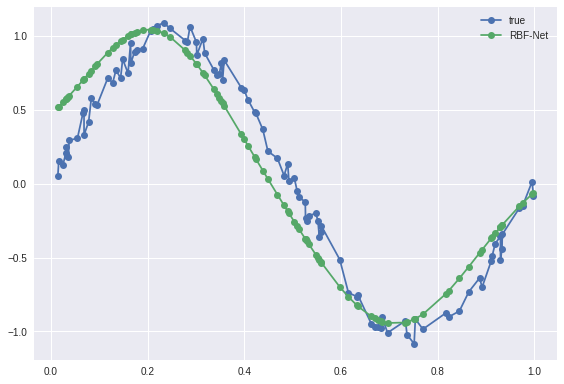

In [24]:
# sample inputs and add noise
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X)  + noise

rbfnet = RBFNet(lr=1e-2, k=2, rbf=rbfGaussiana, inferStds=True)
rbfnet.fit(X, y)

y_pred = rbfnet.predict(X)

errorabs = abs(y-y_pred)
print('error: ' , np.sum(errorabs[0]/NUM_SAMPLES, axis=0))


plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()

## (ERRO) Executando com Base de Dados

In [0]:
data = local + 'train-mod.csv'
sigma = 1.2
itergd = 300

dataread = np.genfromtxt(data, delimiter=',')[1:,1:]

alldata = []
for i in range(len(dataread)):
  if np.isnan(dataread[i,-2]):
      continue
  alldata.append(dataread[i])

alldata = np.asarray(alldata)

#dividing data
trainparam = alldata[:600,1:]
trainlabel = alldata[:600,0]
testparam = alldata[600:,1:]
testlabel = alldata[600:,0]

###############
#normalization#
###############
std = np.zeros((len(trainparam[0]))).astype('float32')
rata = np.zeros((len(trainparam[0]))).astype('float32')
trainparamnorm = np.zeros(np.shape(trainparam))
testparamnorm = np.zeros(np.shape(testparam))
for i in range(len(trainparam[0])):
  std[i] = np.std(trainparam[:,i])
  rata[i] = np.mean(trainparam[:,i])
  #trainparamnorm[:,i] = (trainparam[:,i] - rata[i]) / std[i]
  #testparamnorm[:,i] = (testparam[:,i] - rata[i]) / std[i]

  
rbfnet = RBFNet(lr=1e-2, k=2, rbf=rbfGaussiana, inferStds=True)
rbfnet.fit(trainparamnorm, trainlabel)

y_pred = rbfnet.predict(testparamnorm)

errorabs = abs(y-y_pred)
print('error: ' , np.sum(errorabs[0]/NUM_SAMPLES, axis=0))

# Descrição Mini Projeto

Utilizando o código acima, modifique a última seção (Executando com Base de Dados) para que ele seja executado com a base de dados do arquivo train-mod.csv. Depois, modifique a função de base radial implementada (Gaussiana), para a Multiquadrática e a Multiquadrática Inversa e calcule a taxa de erro.

1 - Calcular o taxa de erro no conjunto de teste na RBF utilizando a base de dados train-mod.csv

2- Calcular a taxa de erro usando 3 funções de Base Radial:
a) Gaussiana
b) Multiquadrática
c) Multiquadrática Inversa


DATA DE ENTREGA: 02/04/2019


## (CORREÇÃO) Executando com Base de Dados

## Calculando a taxa de erro

### Utilizando -> Função de Base Radial Gaussiana

### Utilizando -> Função de Base Radial Multiquadrática

### Utilizando -> Função de Base Radial Multiquadrática Inversa